# Bayesian hypotheses comparison on sequential data with HypTrails

In this tutorial, we present the HypTrails approach that allows to compare hypotheses about sequential data. For more information, please also refer to an <a href="http://nbviewer.jupyter.org/github/psinger/HypTrails/blob/master/tutorial/hyptrails_tutorial.ipynb">extended HypTrails notebook</a> that also covers Bayesian basics.

## Wikispeedia human Web navigation example

### Data

As previously, we load our data into a list of lists where each element corresponds to a sequence.

In [148]:
import csv
sequences = []

# from https://snap.stanford.edu/data/wikispeedia.html
for line in csv.reader((row for row in open("data/paths_finished.tsv") if not row.startswith('#')), delimiter='\t'):
    if len(line) == 0:
        continue
    seq = line[3].split(";")
    # for simplicity, let us remove back clicks
    seq = [x for x in seq if x != "<"]
    sequences.append(seq)

In [149]:
print sequences[:10]

[['14th_century', '15th_century', '16th_century', 'Pacific_Ocean', 'Atlantic_Ocean', 'Accra', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Europe', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Niger', 'Nigeria', 'British_Empire', 'Slavery', 'Africa', 'Atlantic_slave_trade', 'African_slave_trade'], ['14th_century', 'Renaissance', 'Ancient_Greece', 'Greece'], ['14th_century', 'Italy', 'Roman_Catholic_Church', 'HIV', 'Ronald_Reagan', 'President_of_the_United_States', 'John_F._Kennedy'], ['14th_century', 'Europe', 'North_America', 'United_States', 'President_of_the_United_States', 'John_F._Kennedy'], ['14th_century', 'China', 'Gunpowder', 'Fire'], ['14th_century', 'Time', 'Isaac_Newton', 'Light', 'Color', 'Rainbow'], ['14th_century', 'Time', 'Light', 'Rainbow'], ['14th_century', '15th_century', 'Plato', 'Nature', 'Ultraviolet', 'Color', 'Rainbow']]


In [150]:
len(sequences)

51318

### Markov Chain Model

We now implement the Markov Chain Model.

In [158]:
from __future__ import division

import itertools
from scipy.sparse import csr_matrix
from scipy.special import gammaln
from collections import defaultdict
from sklearn.preprocessing import normalize
import numpy as np

class HypTrails():
    """
    HypTrails
    """

    def __init__(self, vocab=None):
        """
        Constructor for class HypTrails
        
        Args:
            vocab: optional vocabulary mapping states to indices
        """
        
        self.vocab = vocab

    def fit(self, sequences):
        """
        Function for fitting the Markov Chain model given data
        
        Args:
            sequences: Data of sequences, list of lists
        """
        
        # first, we derive all basic states from given sequences
        states = set(itertools.chain.from_iterable(sequences))
        self.state_count = len(states)

        # dictionary of dictionaries for counting transitions between states
        transitions = defaultdict(lambda : defaultdict(float))
        
        # vocabulary for mapping states to indices
        if self.vocab is None:
            self.vocab = dict((v,k) for k,v in enumerate(states))
    
        i_indices = []
        j_indices = []
        values = []

        # iterate through sequences
        for seq in sequences:
            i = 0
            # iterate through elements of a sequence
            for j in xrange(1, len(seq)):
                elemA = seq[i]
                elemB = seq[j]
                i += 1
                
                i_indices.append(self.vocab[elemA])
                j_indices.append(self.vocab[elemB])
                values.append(1.)
        
        shape = (self.state_count, self.state_count)
        self.transitions = csr_matrix((values, (i_indices, j_indices)),
                                 shape=shape)

        #print "fit done"

    def evidence(self, hypothesis, k=1, prior=1.):
        """
        Determines Bayesian evidence given fitted model and hypothesis
        
        Args:
            hypothesis: Hypothesis csr matrix, 
                        indices need to map those of transition matrix
            k: Concentration parameter k
            prior: proto Dirichlet prior
        Returns
            evidence
        """
        
        chips = k * self.state_count
        
        if hypothesis.size != 0:
            # in case of memory issues set copy to False but then care about changed hypothesis matrix
            hypothesis = normalize(hypothesis, axis=1, norm='l1', copy=True)

            # distribute chips to matrix, row-based approach
            hypothesis = hypothesis * chips

            # also consider those rows which only include zeros
            norma = hypothesis.sum(axis=1)
            n_zeros,_ = np.where(norma == 0)
            hypothesis[n_zeros,:] = chips / self.state_count
        else:
            # if hypothesis matrix is empty, we can simply increase the proto prior parameter
            prior += k
        
        # transition matrix with additional Dirichlet prior
        # not memory efficient
        transitions_prior = self.transitions.copy()
        transitions_prior = transitions_prior + hypothesis
        
        # elegantly calculate evidence
        evidence = 0
        evidence += gammaln(hypothesis.sum(axis=1)+self.state_count*prior).sum()
        evidence -= gammaln(self.transitions.sum(axis=1)+hypothesis.sum(axis=1)+self.state_count*prior).sum()
        evidence += gammaln(transitions_prior.data+prior).sum()
        evidence -= gammaln(hypothesis.data+prior).sum() + (len(transitions_prior.data)-len(hypothesis.data)) * gammaln(prior)
        return evidence

### Fitting

Before we pay attention to comparing hypotheses, we fit the Markov chain model to given Wikispeedia data.

In [159]:
ht = HypTrails()
ht.fit(sequences)

### Hypotheses

Now, let us specify some hypotheses for our Wikispeedia data at hand.

#### Uniform hypothesis

We start with a uniform hypothesis where we equally believe in each transition. This can be seen as a baseline hypothesis.

In [153]:
# we can use an empty matrix here as the HypTrails class then 
# properly distributes the chips for elicitation
hyp_uniform = csr_matrix((ht.state_count,ht.state_count))

#### Self-loop hypothesis

This hypothesis just believes that people refresh the page over and over again.

In [154]:
from scipy.sparse import lil_matrix

# the hypothesis matrix simply has the diagonal set to 1
hyp_selfloop = lil_matrix((ht.state_count,ht.state_count))
hyp_selfloop.setdiag(1.)
hyp_selfloop = hyp_selfloop.tocsr()

#### Structural hypothesis

One, potentially plausible, hypothesis could be that people prefer to navigate between pages if a hyperlinks between these pages exists. We can express this hypothesis by an adjacency matrix based on given underlying link network. If a link exists, we believe in given transition.

In [179]:
i_indices = []
j_indices = []
values = []

# read the links from file and build matrix
for line in csv.reader((row for row in open("data/links.tsv") if not row.startswith('#')), delimiter='\t'):
    if len(line) == 0:
        continue
    if line[0] in ht.vocab and line[1] in ht.vocab:
        i_indices.append(ht.vocab[line[0]])
        j_indices.append(ht.vocab[line[1]])
        values.append(1.)
        
shape = (ht.state_count, ht.state_count)
hyp_structural = csr_matrix((values, (i_indices, j_indices)),
                         shape=shape)

#### Semantic similarity hypothesis

Finally, related work has proposed that humans prefer to navigate by semantic similarity between consecutive websites. We formalize this as a hypothesis based on textual tf-idf similarity between Wikipedia pages.

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer

articles = np.empty((ht.state_count,),dtype=object)

# add the article text to the array
for k,v in ht.vocab.iteritems():
    articles[v] = open("data/plaintext_articles/"+k+".txt").read()

# build tf-idf features
vect = TfidfVectorizer(max_df=0.8, sublinear_tf=True)
X = vect.fit_transform(articles)

# all-pairs cosine similarity
hyp_similarity = X * X.T

TypeError: cannot concatenate 'str' and 'int' objects

### Comparing hypotheses

Now, let us compare the plausibility of given hypotheses given the data and some values of k.

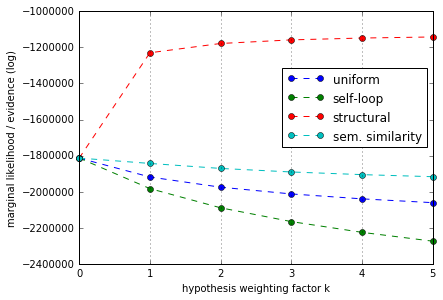

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

# uniform hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_uniform,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="uniform", linestyle='--')

# self-loop hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_selfloop,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="self-loop", linestyle='--')

# structural hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_structural,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="structural", linestyle='--')

# semantic similarity hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_similarity,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="sem. similarity", linestyle='--')

# further plotting
ax.set_xlabel("hypothesis weighting factor k")
ax.set_ylabel("marginal likelihood / evidence (log)")

plt.legend(bbox_to_anchor=(1,0.8),loc="upper right", handlelength = 3)
plt.grid(False)
ax.xaxis.grid(True)
plt.tight_layout(pad=0.2)

In above figure, we can see the results for comparing four hypotheses about the production of our sequences at interest; each hypothesis is depicted in a distinct color. The x-axis reports the hypothesis weighting factor k that corresponds to the level of belief in a given hypothesis---the higher the fewer parameter configurations receive corresponding belief in the Dirichlet prior. The y-axis reports the evidence. Note that for simplicity, we now state that higher evidence (for the same values of k) mean higher plausibility. For completeness, Bayes factors should be computed to judge the strength of the differences.

Not surprisingly, the structural hypothesis is the most plausible one. After all, Wikispeedia players are only allowed to utilize hyperlinks for navigation. But, also the semantic similarity hypothesis is more plausible than the uniform hypothesis.

## Synthetic example

Next, let us consider a synthetic example where we know the mechanisms creating given sequences. In detail, we create a synthetic graph and generate synthetic sequences by letting a random walker walk through this graph. We then compare some hypotheses with each other which should further demonstrate the mechanics of HypTrails.

### Synthetic data generation

First, we generate a random graph. To that end, we create a Barabasi-Albert random network with 13 nodes and new nodes are attached to the existing graph with 2 edges. The graph layout is visualized.

Note that this network is undirected. However, there are also extensions that allow to generate directed Barabasi-Albert networks. For simplicity, we focus on the undirected case here though.

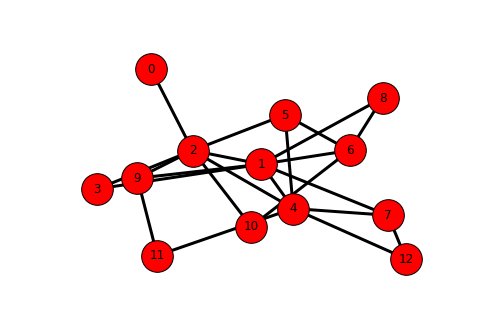

In [163]:
import networkx as nx

g = nx.barabasi_albert_graph(13, 2)
nx.draw(g, with_labels=True, node_size=1000, width=3)

Next, we let a random walker run through the network. At each step, the walker chooses one out-link at random. Overall, we generate 100 trails with a length of 5 for each one.

In [164]:
from random import choice

# let us create 100 individual sequences
i = 100
sequences = []
while(i>0):
    # pick random vertex of G
    v = choice(g.nodes())
    seq = []
    seq.append(v)
    # let us try to produce sequences with length 5
    x=4
    while x>0:
        # pick random neighbor node
        v = choice(g.neighbors(v))
        seq.append(v)
        x -= 1

    i-=1
    sequences.append(seq)

# show some trails
print sequences[:10]

[[6, 5, 2, 0, 2], [11, 9, 2, 5, 4], [4, 7, 4, 5, 4], [5, 4, 7, 4, 12], [2, 5, 4, 11, 4], [11, 4, 1, 2, 9], [12, 7, 12, 7, 1], [6, 10, 2, 1, 4], [3, 2, 9, 2, 0], [0, 2, 3, 1, 4]]


Next, we visualize one random walk on the network which ends in one sequence out of the set of 100 sequences.

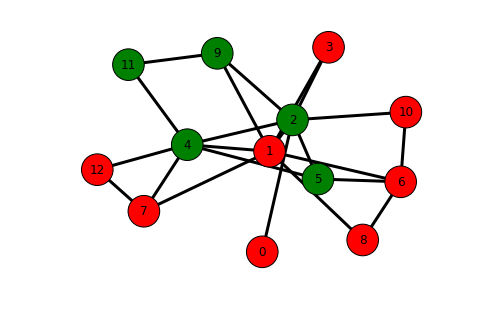

In [169]:
# find a sequence with distinct nodes for visibility reasons
i = 0
for seq in sequences:
    if len(seq) == len(set(seq)):
        break
    i += 1

node_colors=[]
for n in g.nodes():
    if n in sequences[i]:
        node_colors.append('g')
    else:
        node_colors.append('r')
        
edge_colors=[]
for e in g.edges():
    try:
        idx1 = trails[i].index(e[0])
        idx2 = trails[i].index(e[1])
        if idx1 + 1 == idx2:
            edge_colors.append('g')
        elif idx2 + 1 == idx1:
            edge_colors.append('g')
        else:
            edge_colors.append('black')
    except:
        edge_colors.append('black')
        continue
        
nx.draw(g, with_labels=True, node_size=1000, node_color = node_colors, edge_color = edge_colors, width=3)

### Fitting

Again, we start by fitting the model.

In [171]:
ht = HypTrails()
ht.fit(sequences)
vocab = ht.vocab

### Hypotheses

Now, having the data to study, we want to compare some exemplary hypotheses with each other. Each hypothesis should express a certain belief about the mechanisms producing the sequences at hand. Remember that each hypothesis can be expressed via belief in parameters of a Markov chain model. We define some hypotheses next.

#### Uniform hypothesis

As before, the uniform hypothesis can be seen as a baseline and believes in random transitions.

In [173]:
# we can use an empty matrix here as the HypTrails class then 
# properly distributes the chips for elicitation
hyp_uniform = csr_matrix((ht.state_count,ht.state_count))

#### Structural hypothesis

With this hypothesis we want to express our belief that the sequences at interest have been generated by a walker that randomly chooses hyperlinks to go to the next node---this means that we do not believe in teleportation here.

In [174]:
i_indices = list()
j_indices = list()
values = list()
# let us iterate through all nodes
for k,v in vocab.iteritems():
    # get the neighbors of each node (i.e., those nodes the current node links to)
    # and set the corresponding value of the hypothesis matrix G to 1
    for w in g.neighbors(k):
        i_indices.append(v)
        j_indices.append(vocab[w])
        values.append(1)

shape = (ht.state_count, ht.state_count)

hyp_structural = csr_matrix((values, (i_indices, j_indices)),
                             shape=shape, dtype=np.float64)

#### Data hypothesis

Here, we also want to show that a data hypothesis always gets ranked as the most plausible hypothesis and thus, is an upper limit. In detail, a data hypothesis "cheats" by taking the actual transitions for expressing beliefs of the hypothesis. Note that extracting information from the data and use it as a hypothesis is no valid approach and this example should only provide a better understanding of the relative behavior of various hypotheses.

In [175]:
hyp_data = ht.transitions.copy()

### Comparing hypothesis

Again, we compare the hypotheses with varying concentration parameters k.

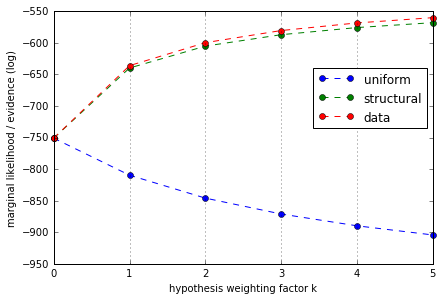

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

# uniform hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_uniform,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="uniform", linestyle='--')

# structural hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_structural,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="structural", linestyle='--')

# sdata hypothesis
evidences = []
for k in xrange(0,6):
    if k == 0:
        evidences.append(ht.evidence(csr_matrix((ht.state_count,ht.state_count)),k))
    else:
        evidences.append(ht.evidence(hyp_data,k))
ax.plot(np.arange(0,6), evidences, marker='o', clip_on = False, label="data", linestyle='--')

# Further plotting
ax.set_xlabel("hypothesis weighting factor k")
ax.set_ylabel("marginal likelihood / evidence (log)")

plt.legend(bbox_to_anchor=(1,0.8),loc="upper right", handlelength = 3)
plt.grid(False)
ax.xaxis.grid(True)
plt.tight_layout(pad=0.2)

Overall, the results accurately represent what we expected as we know the underlying mechanisms producing the synthetic sequences at interest. We can see that the data hypothesis is the most plausible one which also was to be expected as it is built by taking the actual transitions from the data. The structural hypothesis represents a good explanation of the synthetically-produced sequences as it encodes the strategy of the walker---i.e., choosing any out-link at random at each step. 